# 勉強会：　データサイエンスの基本

-----------------

## agenda
- データサイエンスは何か？
- 慣用ライブラリ
- 機械学習の基礎
- データ前処理
- モデル種類・紹介
- 誤差メトリクス
- 特徴量


-----------

## データサイエンスは何か？

データサイエンスとは、データから価値ある**__インサイト__**を抽出し、意思決定に活用する学問・技術分野です。

### データサイエンスのプロセス：

問題定義 → データ収集 → <u>データクリーニング</u> → <u>データ分析</u> → <u>モデリング</u> → <u>評価</u> → デプロイ → モニタリング

今回はこの四つのステップについで話したいと思います。

------------
## 慣用ライブラリ

順番ではないですが、まずは一番簡単なデータ分析から話しましょう。

基本的にデータ分析＝データを見る。pythonのデータ可視化慣用ライブラリいくつか紹介したいと思います

In [1]:
!uv pip install numpy pandas matplotlib seaborn plotly scikit-learn xgboost statsmodels torch xgboost

Using Python 3.11.14 environment at: /Users/yifever/Projects/ssr-experiments/.venv
Audited 10 packages in 23ms


In [2]:
import numpy as np           # 数値計算
import pandas as pd          # データ操作

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


### データを生成します

365日分の売上データを生成します
- 日付
- 製品名
- カテゴリ
- 売上金額
- 販売数
- 地域

In [3]:
# シード設定（再現性のため）
np.random.seed(12)

# 基本パラメータ
n_samples = 365
dates = pd.date_range(start='2024-01-01', periods=n_samples, freq='D')

# 製品とカテゴリの紐付け
product_category_mapping = {
    'Product A': 'Electronics',
    'Product B': 'Clothing',
    'Product C': 'Food',
    'Product D': 'Books',
}

regions = ['Tokyo', 'Osaka', 'Nagoya', 'Fukuoka']

# 各日付、各製品、各地域の組み合わせでデータを生成
data_list = []
for date in dates:
    for product, category in product_category_mapping.items():
        for region in regions:
            sales = np.random.randint(1000, 10000)
            units = np.random.randint(10, 100)
            data_list.append({
                'date': date,
                'product': product,
                'category': category,
                'region': region,
                'sales': sales,
                'units': units
            })

sales_data = pd.DataFrame(data_list)

# トレンドと季節性を追加
day_index = np.repeat(np.arange(n_samples), len(product_category_mapping) * len(regions))
sales_data['sales'] = sales_data['sales'] + day_index * 5  # トレンド
sales_data['sales'] = sales_data['sales'] + 2000 * np.sin(day_index / 30)  # 季節性

print(f"✓ 売上データを生成しました: {len(sales_data)} 行")
print(f"  - 日数: {n_samples}")
print(f"  - 製品数: {len(product_category_mapping)}")
print(f"  - 地域数: {len(regions)}")
print(f"  - 総数: {n_samples} × {len(product_category_mapping)} × {len(regions)} = {len(sales_data)}")

✓ 売上データを生成しました: 5840 行
  - 日数: 365
  - 製品数: 4
  - 地域数: 4
  - 総数: 365 × 4 × 4 = 5840



### pandas: テーブルビュー

詳細は[doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

In [4]:
sales_data.sort_values(by='date', ascending=False).head(10)

date    product     category   region        sales  units
5839 2024-12-30  Product D        Books  Fukuoka   9680.74068     49
5831 2024-12-30  Product B     Clothing  Fukuoka   2903.74068     47
5824 2024-12-30  Product A  Electronics    Tokyo   8226.74068     29
5825 2024-12-30  Product A  Electronics    Osaka   6678.74068     49
5826 2024-12-30  Product A  Electronics   Nagoya   7411.74068     85
5827 2024-12-30  Product A  Electronics  Fukuoka  10899.74068     83
5829 2024-12-30  Product B     Clothing    Osaka   9018.74068     64
5830 2024-12-30  Product B     Clothing   Nagoya   3173.74068     17
5828 2024-12-30  Product B     Clothing    Tokyo  10154.74068     38
5832 2024-12-30  Product C         Food    Tokyo  10633.74068     63

### Matplotlib - 基本的な可視化
[doc](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)

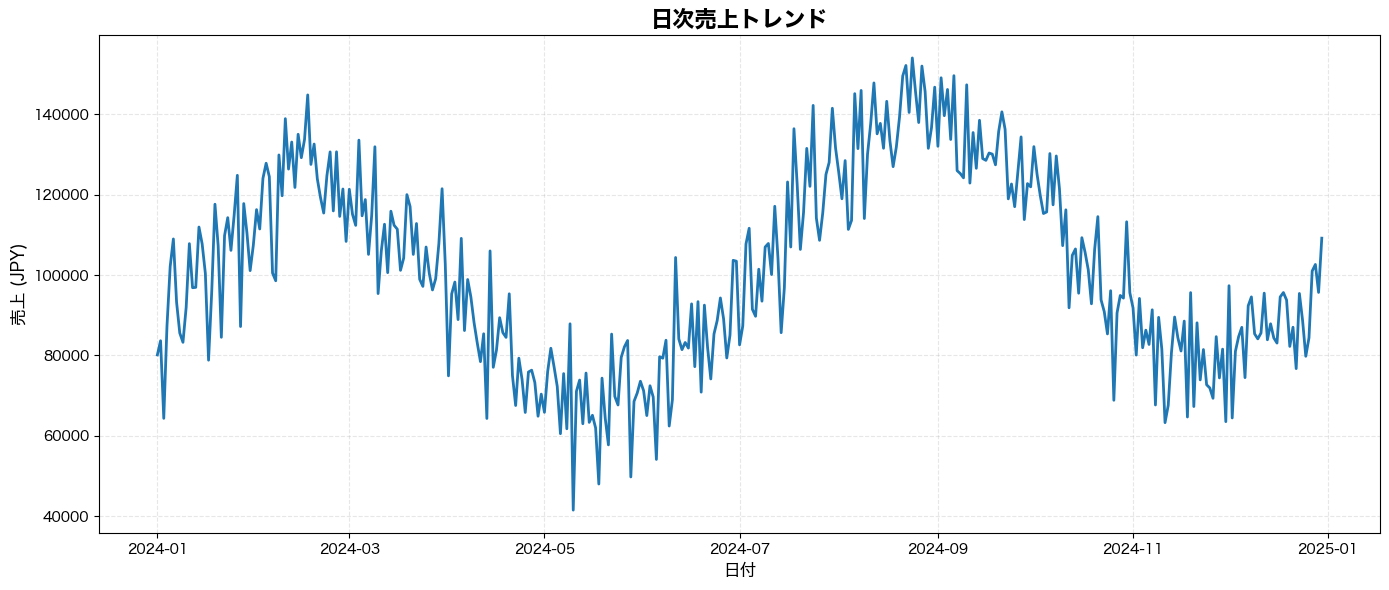

In [5]:
import matplotlib.pyplot as plt  # 基本的な可視化
from matplotlib import rcParams

# 日本語フォントの設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic']


# 日次売上を集計
daily_sales = sales_data.groupby('date')['sales'].sum()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales.values, color='#1f77b4', linewidth=2)
plt.title('日次売上トレンド', fontsize=16, fontweight='bold')
plt.xlabel('日付', fontsize=12)
plt.ylabel('売上 (JPY)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Seaborn - 統計的可視化

[doc](https://seaborn.pydata.org/api.html)

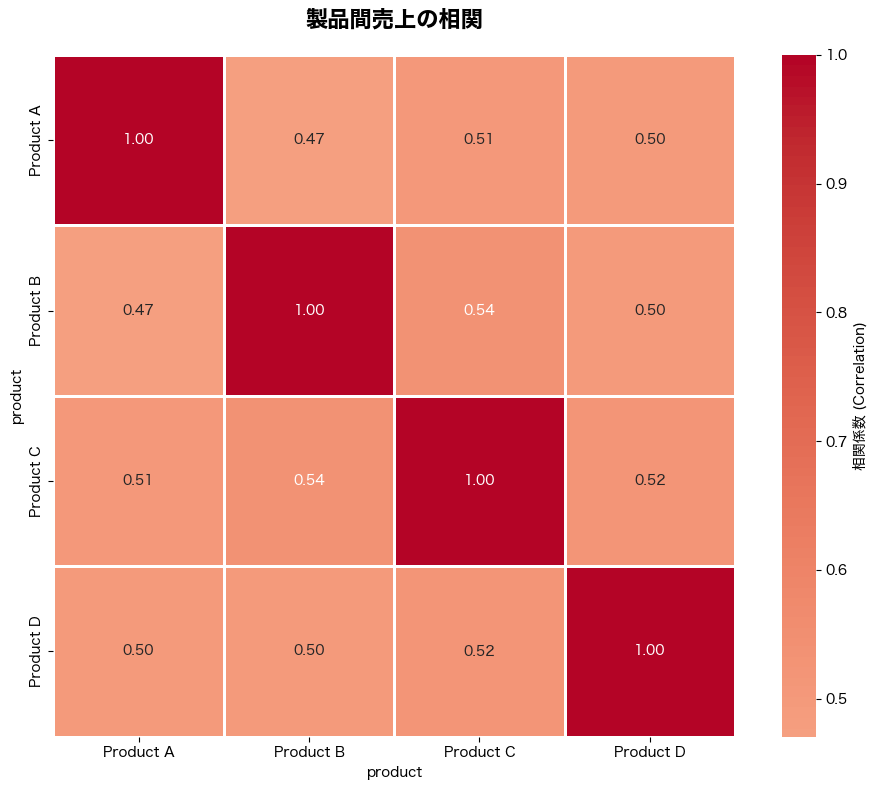

In [6]:
import seaborn as sns       # 統計的可視化

# 各製品の日次売上を集計してピボット
product_daily_sales = sales_data.groupby(['date', 'product'])['sales'].sum().unstack(fill_value=0)

# 相関行列を計算
correlation_matrix = product_daily_sales.corr()

# 相関ヒートマップを作成
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={'label': '相関係数 (Correlation)'})
plt.title('製品間売上の相関', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### 相関の計算 
<details>
<summary>Click to expand</summary>


d: date

p: product

r: region

R: region総数

T: trend

S: seasonality

X: sales

$$
\begin{align}

\text{corr}(X_{p=A}, X_{p=B}) &= \frac{\text{COV}(X_{p=A}, X_{p=B})}{\sigma_{X_{p=A}}\sigma_{X_{p=B}}} \\
 &= \frac{\text{COV}(X_{p=A}, X_{p=B})}{\sigma_{X_{p}}^2} 

\end{align}\\[2em]

\begin{align}

X_{p} &= \sum_{r=1}^{R} (\text{U}_{d,p,r} + \text{T}_d + \text{S}_d) \\
&= \sum_{r=1}^{R}\text{U}_{d,p,r} + \sum_{r=1}^{R}\text{T}_d + \sum_{r=1}^{R}\text{S}_d 
\end{align} \\[2em]


\begin{align}

\text{COV}(X_{p=A}, X_{p=B}) &= \text{COV}(\sum_{r=1}^{R}\text{U}_{d,p,r} + \sum_{r=1}^{R}\text{T}_d + \sum_{r=1}^{R}\text{S}_d, \sum_{r=1}^{R}\text{U}_{d,p,r} + \sum_{r=1}^{R}\text{T}_d + \sum_{r=1}^{R}\text{S}_d) \\[2em]
&=  \text{VAR}(R\text{T}_d) + \text{VAR}(R\text{S}_d) + \text{COV}(R\text{T}_d, R\text{S}_d) \\
&=  R^2 (\text{VAR}(\text{T}_d) + \text{VAR}(\text{S}_d) + \text{COV}(\text{T}_d, \text{S}_d))

\end{align}\\[2em]


\text{VAR}(\text{T}_d) = \frac{5^2 (364)^2}{12} \approx 276033 \\[2em]
\text{VAR}(\text{S}_d) = 2000^2 \text{VAR}(sin(i/30)) \approx 2000^2 (1/2) \approx 2000000 \\[2em]

\begin{align}

\text{COV}(\text{T}_d, \text{S}_d) &=  E[TS] - E[T] \cdot E[S] \\ 
&\approx E[TS] \hspace{2em} (E[S] \approx 0)\\
&= \frac{1}{365}\sum_{d=0}^{364} (5d)(2000\sin(d/30)) \\
&= \frac{10,000}{365}\sum_{d=0}^{364} d\sin(d/30) \\
&\approx -283977
\end{align}
\\[2em]
\begin{align}
\text{COV}(X_{p=A}, X_{p=B}) &= R^2 (276033 + 2000000 -283977) \\ 
&= R^2 \times 1992056 \\
\end{align}\\[2em]
\begin{align} 

\sigma_{X} &= R^2 (276033 + 2000000 -283977) + \text{VAR}(\sum_{r=1}^{R} U) \\
&= R^2 \times 1992056 + R \frac{(10000-1000) ^ 2}{12} 
\end{align}
$$

R = 4 の時:
$$
\begin{align}

\text{corr}(X_{p=A}, X_{p=B}) &= \frac{4^2 \times 1992056}{4^2 \times 1992056 + 4 \frac{9000^2}{12}} \\
&=0.54

\end{align}\\[2em]

$$

## Q. なんで理論上の計算値と実際取った数字が違いますか？
<details>
<summary>Hint</summary>
E[S]を実際計算してみましよう。
</details>

</details>

### 組み合わせ例


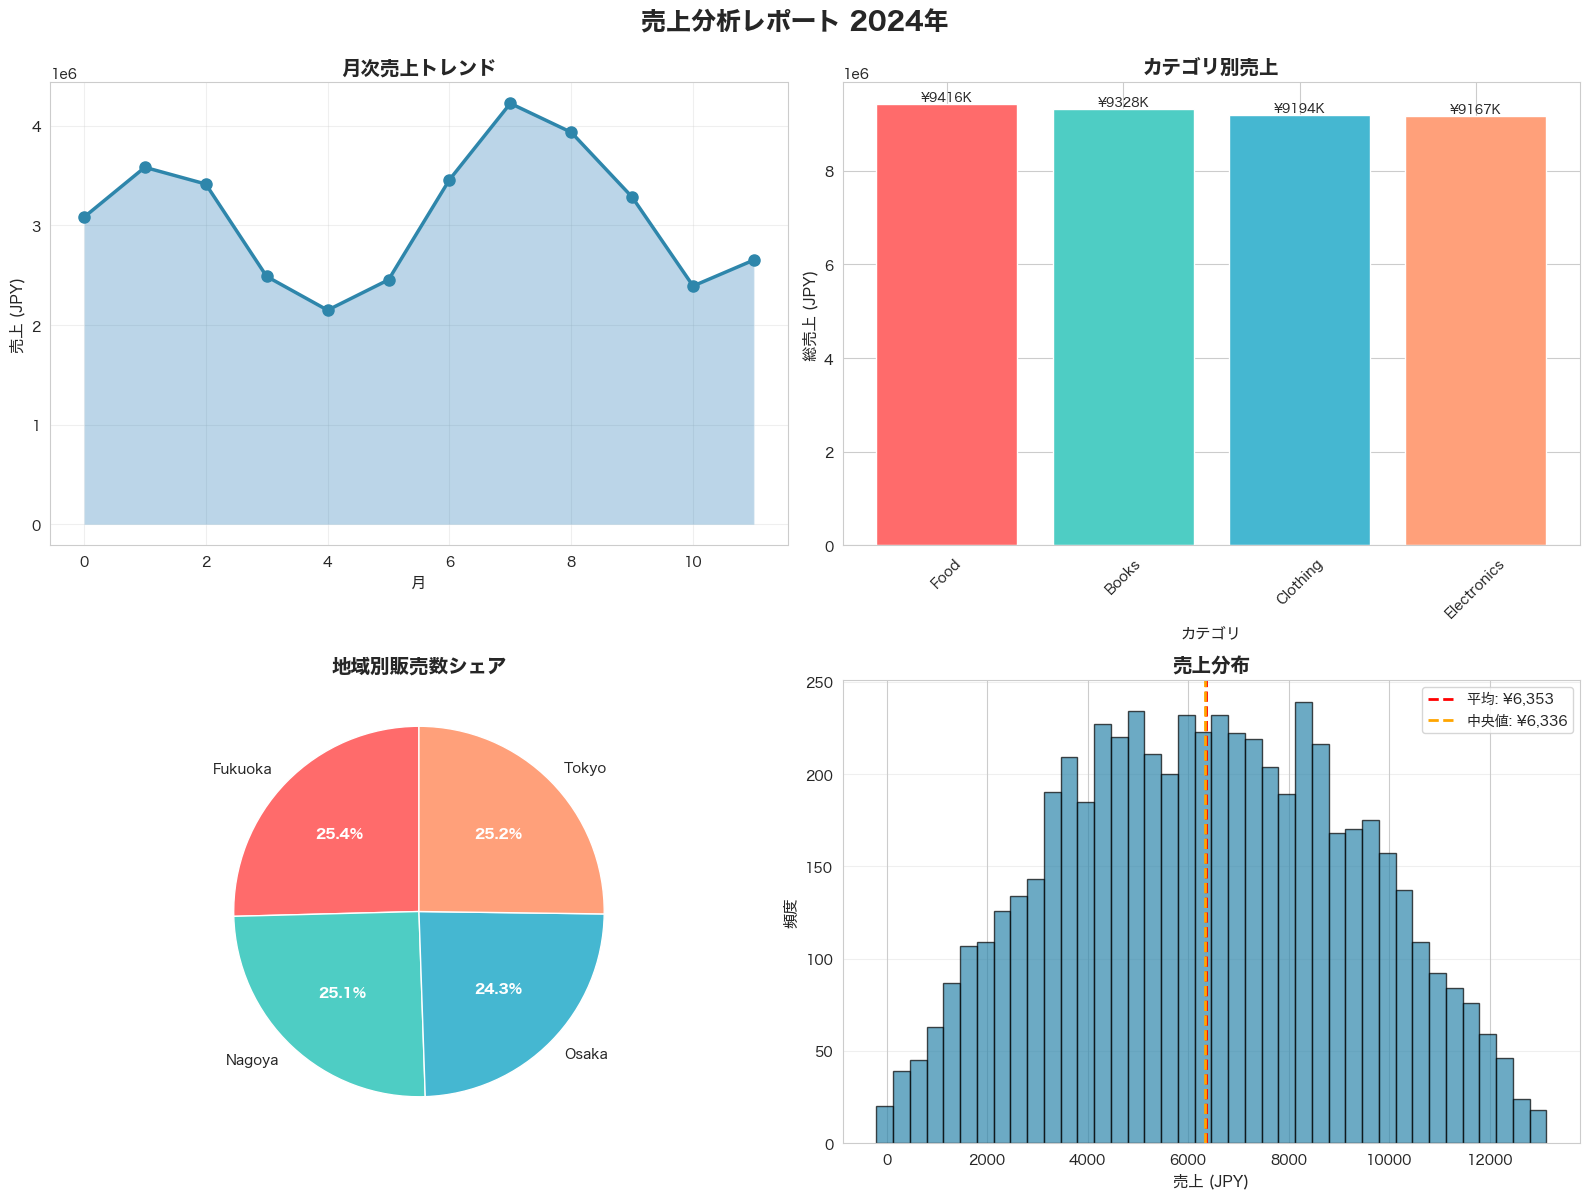

In [7]:
# スタイル設定
sns.set_style("whitegrid")

# 日本語フォントの設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic']

# 4つのサブプロット
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('売上分析レポート 2024年', 
             fontsize=18, fontweight='bold', y=0.995)

# 1. 月次売上トレンド
sales_data['month'] = sales_data['date'].dt.to_period('M')
monthly_sales = sales_data.groupby('month')['sales'].sum()
axes[0, 0].plot(range(len(monthly_sales)), monthly_sales.values, 
                marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
axes[0, 0].set_title('月次売上トレンド', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('月', fontsize=11)
axes[0, 0].set_ylabel('売上 (JPY)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].fill_between(range(len(monthly_sales)), monthly_sales.values, alpha=0.3)

# 2. カテゴリ別売上
category_sales = sales_data.groupby('category')['sales'].sum().sort_values(ascending=False)
bars = axes[0, 1].bar(category_sales.index, category_sales.values, 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0, 1].set_title('カテゴリ別売上', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('カテゴリ', fontsize=11)
axes[0, 1].set_ylabel('総売上 (JPY)', fontsize=11)
axes[0, 1].tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'¥{height/1000:.0f}K', ha='center', va='bottom', fontsize=9)

# 3. 地域別販売数シェア
region_units = sales_data.groupby('region')['units'].sum()
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
wedges, texts, autotexts = axes[1, 0].pie(region_units.values, 
                                           labels=region_units.index,
                                           autopct='%1.1f%%',
                                           colors=colors_pie,
                                           startangle=90)
axes[1, 0].set_title('地域別販売数シェア', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 4. 売上分布
axes[1, 1].hist(sales_data['sales'], bins=40, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('売上分布', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('売上 (JPY)', fontsize=11)
axes[1, 1].set_ylabel('頻度', fontsize=11)
axes[1, 1].axvline(sales_data['sales'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'平均: ¥{sales_data["sales"].mean():,.0f}')
axes[1, 1].axvline(sales_data['sales'].median(), color='orange', linestyle='--', linewidth=2,
                   label=f'中央値: ¥{sales_data["sales"].median():,.0f}')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

------------
## 機械学習の基礎

機械学習とは、コンピューターが大量のデータからパターンやルールを自動で学習し、その学習結果をもとに予測や分類、意思決定などを行う技術です。

### 機械学習の3つのタイプ

- 教師あり学習（Supervised Learning）
  - **定義**: ラベル付きデータから学習し、新しいデータを予測

  - 分類（Classification）
    - **目的**: データをカテゴリに分類
    - **例**:
      - 画像認識（猫/犬/鳥）
      - 病気診断（陽性/陰性）

  - 回帰（Regression）
    - **目的**: 連続値を予測
    - **例**:
      - 株価予測
      - 売上予測

- 教師なし学習（Unsupervised Learning）
  - **定義**: ラベルなしデータから隠れたパターンや構造を発見

  - クラスタリング
    - **目的**: 類似したデータをグループ化
    - **例**:
      - 文書のトピック分類
      - 異常検知

- 強化学習（Reinforcement Learning）

  - **定義**: 試行錯誤を通じて最適な行動を学習

  - **概念**: エージェントが環境と相互作用し、報酬を最大化
  - **例**:
    - ゲームAI（囲碁、チェス）
    - 自動運転




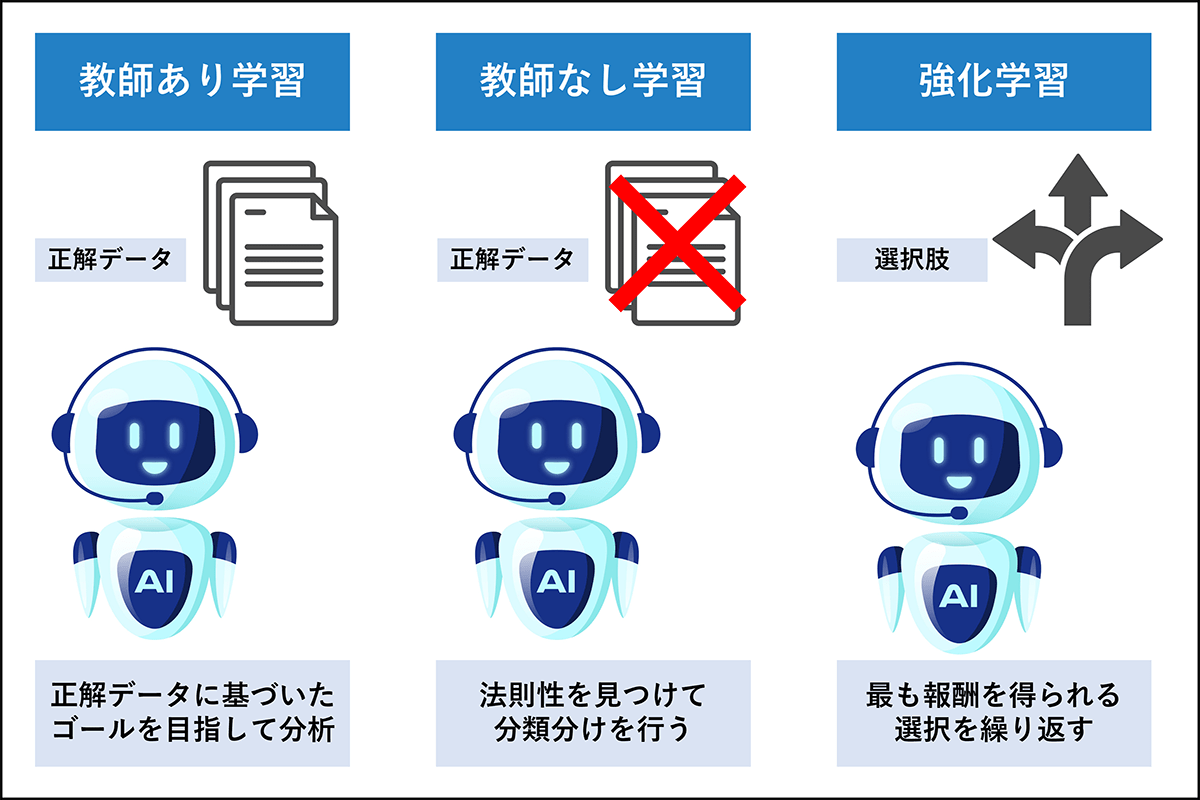

----------
## データ前処理

### 1. 正規化 (Normalization)

正規化は、データの値を特定の範囲（通常は0から1の間）にスケーリングする手法です。データの相対的な関係を保ちながら、すべての値を同じスケールに変換します。

**Min-Max正規化:**

$$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$$

ここで：
- $x$ = 元の値
- $x_{min}$ = データセット内の最小値
- $x_{max}$ = データセット内の最大値
- $x'$ = 正規化後の値（0から1の範囲）

この式により、すべての値が0から1の範囲に変換されます。

**なぜやる:**

- 勾配降下法の収束が早まる
- アルゴリズムの学習が安定する

### 2. 標準化 (Standardization)

標準化は、データの平均を0、標準偏差を1にする変換です。データを「平均からの標準偏差単位」で表現します。これをZ-score（Zスコア）とも呼びます。

**Z-score標準化:**

$$z = \frac{x - \mu}{\sigma}$$

ここで：
- $x$ = 元の値
- $\mu$ = データセットの平均値
- $\sigma$ = データセットの標準偏差
- $z$ = 標準化後の値（Z-score）


この式により、データの中心が0になり、散らばり具合が標準化されます。

**なぜやる:**

- アルゴリズムの学習が安定する
- 異常値の識別が容易

## エンコーディング

エンコーディングは、カテゴリカル変数を複数の二値変数（0または1）に変換する手法です。各カテゴリに対して1つの列を作成し、該当するカテゴリの列のみ1、他は0とします。

**変換例:**

元のデータ：
```
色: [赤, 青, 緑, 赤]
```

変換後：
```
色_赤: [1, 0, 0, 1]
色_青: [0, 1, 0, 0]
色_緑: [0, 0, 1, 0]
```

**表現:**

各サンプル $i$ について、カテゴリ $k$ の場合：

$$x_j^{(i)} = \begin{cases} 1 & \text{if } j = k \\ 0 & \text{otherwise} \end{cases}$$

ここで：
- $x_j^{(i)}$ = サンプル $i$ のカテゴリ $j$ の値
- $k$ = 実際のカテゴリ
- 各サンプルで $\sum_{j=1}^{n} x_j^{(i)} = 1$ （1つだけが1）



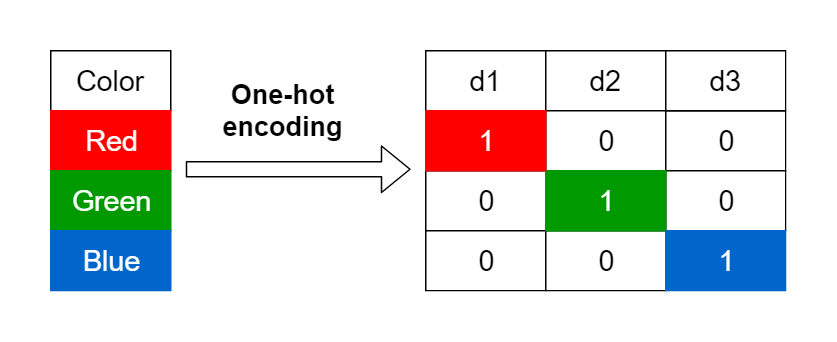

### データ型の変換
データ型の変換は、カラムを適切な型（数値、文字列、日付など）に変更する処理です。多くの場合、データ読み込み時に型が誤って推定されるため、正しい型に変換することで分析や計算が可能になります。

### 前処理例

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

X = sales_data.copy()

# ワンホットエンコーディング実行
X_encoded = pd.get_dummies(X, columns=['product', 'category', 'region'], prefix=['prod', 'cat', 'reg']).astype(int)

# 日付列を数値に変換
if 'date' in X.columns:
    X['date'] = X['date'].astype('int64') / 10**9  # Unixタイムスタンプ（秒）

# 数値列のみを選択
numeric_columns = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
X_numeric = X[numeric_columns].copy()

# =====================================
# 正規化例（Min-Max Normalization）
# =====================================

# salesとunitsを正規化
scaler_minmax = MinMaxScaler()
columns_to_normalize = ['date', 'sales', 'units']

X_normalized = X_numeric.copy()
X_normalized[columns_to_normalize] = scaler_minmax.fit_transform(X_numeric[columns_to_normalize])
y = X_normalized['sales']

X = pd.concat([X_encoded.drop(columns=['date', 'month', 'sales', 'units']), X_normalized[['date', 'sales', 'units']]], axis=1)

X.head(5)

prod_Product A  prod_Product B  prod_Product C  prod_Product D  cat_Books  \
0               1               0               0               0          0   
1               1               0               0               0          0   
2               1               0               0               0          0   
3               1               0               0               0          0   
4               0               1               0               0          0   

   cat_Clothing  cat_Electronics  cat_Food  reg_Fukuoka  reg_Nagoya  \
0             0                1         0            0           0   
1             0                1         0            0           0   
2             0                1         0            0           1   
3             0                1         0            1           0   
4             1                0         0            0           0   

   reg_Osaka  reg_Tokyo  date     sales     units  
0          0          1   0.0  0.524181  0.067416  
1          1          0   0.0  0.339508  0.022472  
2          0          0   0.0  0.110954  0.550562  
3          0          0   0.0  0.369512  1.000000  
4          0          1   0.0  0.735932  0.842697

### データの分割 (Train-Test Split)

トレーニングデータとテストデータの分割は、モデルの性能を正しく評価するために、データを2つのセットに分ける手法です。通常、データの70-90%を学習用、残りの10-30%をテスト用に分割します。

#### 分割の基本概念

**トレーニングデータ (Training Data)**
- モデルの学習に使用するデータ
- モデルはこのデータからパターンを学習する
- 通常、全体の70-90%を使用

**テストデータ (Test Data)**
- モデルの性能評価に使用するデータ
- モデルが**見たことがない**データ
- 通常、全体の10-30%を使用

#### なぜやる

**オーバーフィットの検出**
- トレーニングデータだけで評価すると、モデルがトレーニングデータを「暗記」(memorization)している可能性がある
- テストデータで評価することで、真の汎化性能がわかる
- トレーニング精度は高いがテスト精度が低い → オーバーフィットのサイン

**汎化性能の評価**
- モデルが新しいデータに対してどれだけ正確に予測できるか
- 実世界での性能を推定できる
- 学習の時に見ていないデータでの性能が重要


#### 時系列データの分割例

時系列データでは、**時間順を保つことが重要**です：

```
全データ: [1月, 2月, 3月, 4月, 5月, 6月, 7月, 8月, 9月, 10月]

トレーニングデータ: [1月, 2月, 3月, 4月, 5月, 6月, 7月, 8月, 9月]
テストデータ: [10月]

理由: 過去のデータで学習し、未来のデータで予測する
```

In [9]:
split_idx = int(len(X) * 0.9)

X_train = X[:split_idx].drop(columns=['sales'])
X_test = X[split_idx:].drop(columns=['sales'])
y_train = y[:split_idx]
y_test = y[split_idx:]


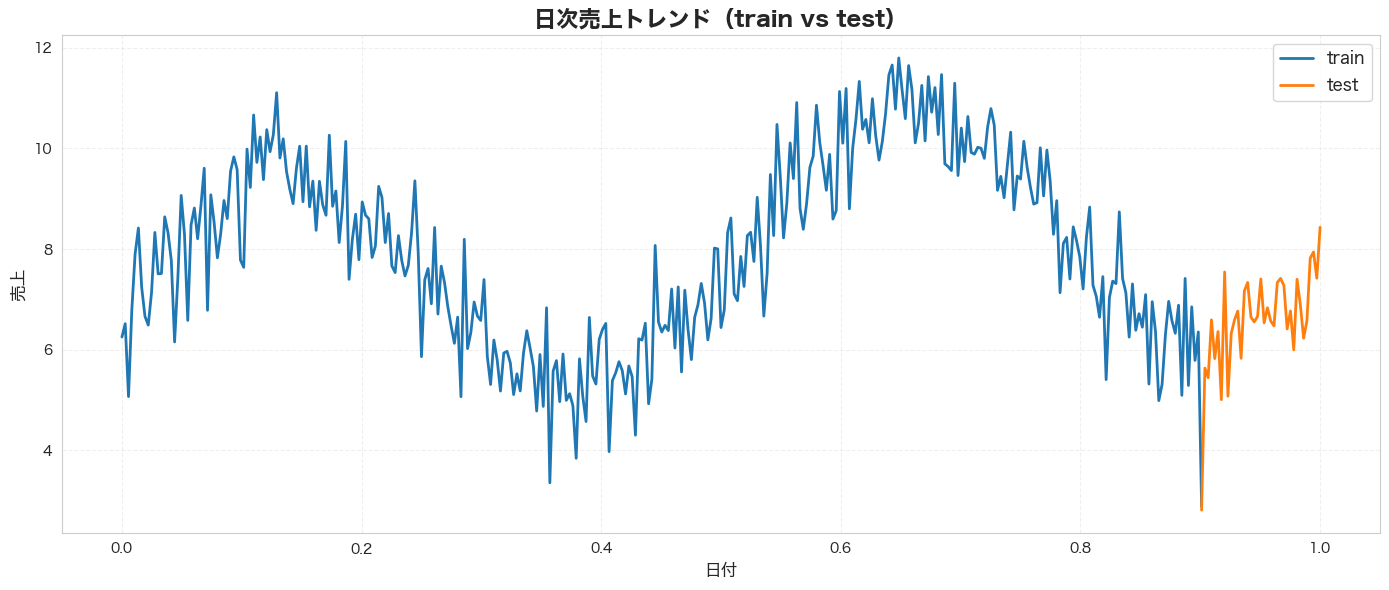

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

train_data = pd.DataFrame({
    'date': X_train['date'].values,
    'sales': y_train.values
})

test_data = pd.DataFrame({
    'date': X_test['date'].values,
    'sales': y_test.values
})

daily_sales_train = train_data.groupby('date')['sales'].sum()
daily_sales_test = test_data.groupby('date')['sales'].sum()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales_train.index, daily_sales_train.values, color='#1f77b4', linewidth=2, label='train')
plt.plot(daily_sales_test.index, daily_sales_test.values, color='#ff7f0e', linewidth=2, label='test')
plt.title('日次売上トレンド（train vs test）', fontsize=16, fontweight='bold')
plt.xlabel('日付', fontsize=12)
plt.ylabel('売上', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

----------
## モデル種類・紹介

In [11]:
# util: モデル予測プロット

def plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train, y_pred_test):
    # 訓練データの集約
    train_results = pd.DataFrame({
        'date': X_train_split['date'],
        'actual': y_train_split.values,
        'predicted': y_pred_train
    })
    
    # テストデータの集約
    test_results = pd.DataFrame({
        'date': X_test_split['date'],
        'actual': y_test_split.values,
        'predicted': y_pred_test
    })

    # 日付ごとに合計
    daily_train = train_results.groupby('date').agg({
        'actual': 'sum',
        'predicted': 'sum'
    }).reset_index()
    
    daily_test = test_results.groupby('date').agg({
        'actual': 'sum',
        'predicted': 'sum'
    }).reset_index()

    # プロット（時系列）
    plt.figure(figsize=(14, 6))
    plt.plot(daily_train['date'], daily_train['actual'], alpha=0.5, label='実績（train）', linewidth=2, color='#1f77b4')
    plt.plot(daily_train['date'], daily_train['predicted'], alpha=0.5, label='予測値（train）', linewidth=2, color='#aec7e8')
    plt.plot(daily_test['date'], daily_test['actual'], alpha=0.7, label='実績（test）', linewidth=2, color='#ff7f0e')
    plt.plot(daily_test['date'], daily_test['predicted'], alpha=0.7, label='予測値（test）', linewidth=2, color='#ffbb78')
    plt.xlabel('日付')
    plt.ylabel('売上')
    plt.title('実績 vs 予測値（日次集計）')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_results.png', dpi=150, bbox_inches='tight')
    plt.show()

### 1. 線形モデル Linear Models

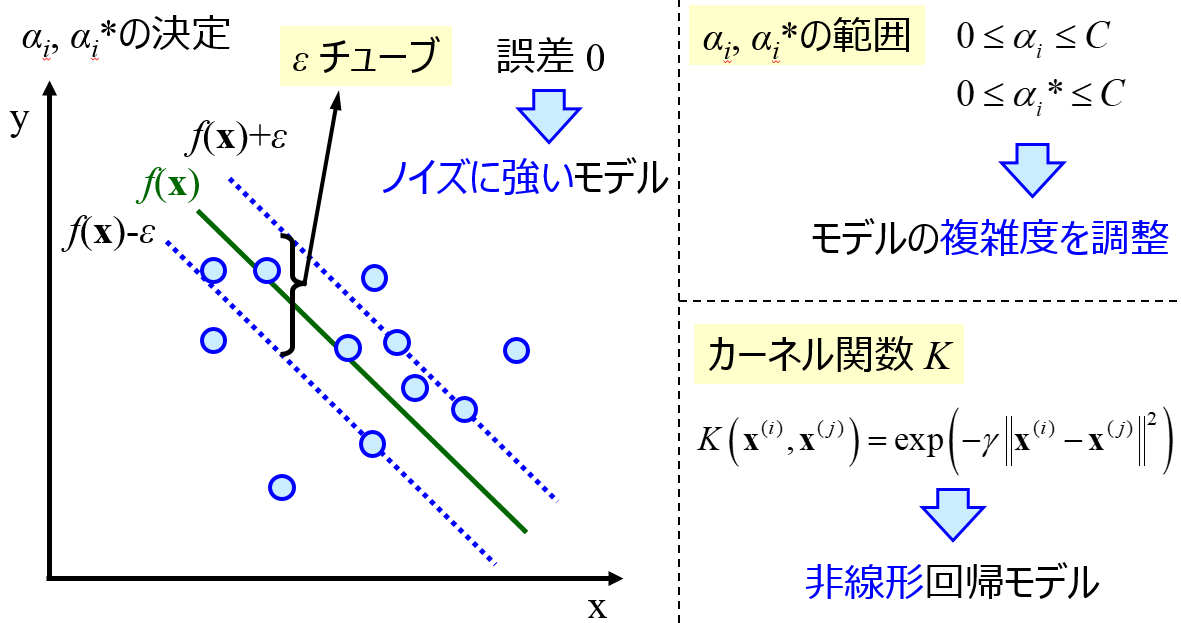

MSE: 0.04
R²スコア: -0.2035


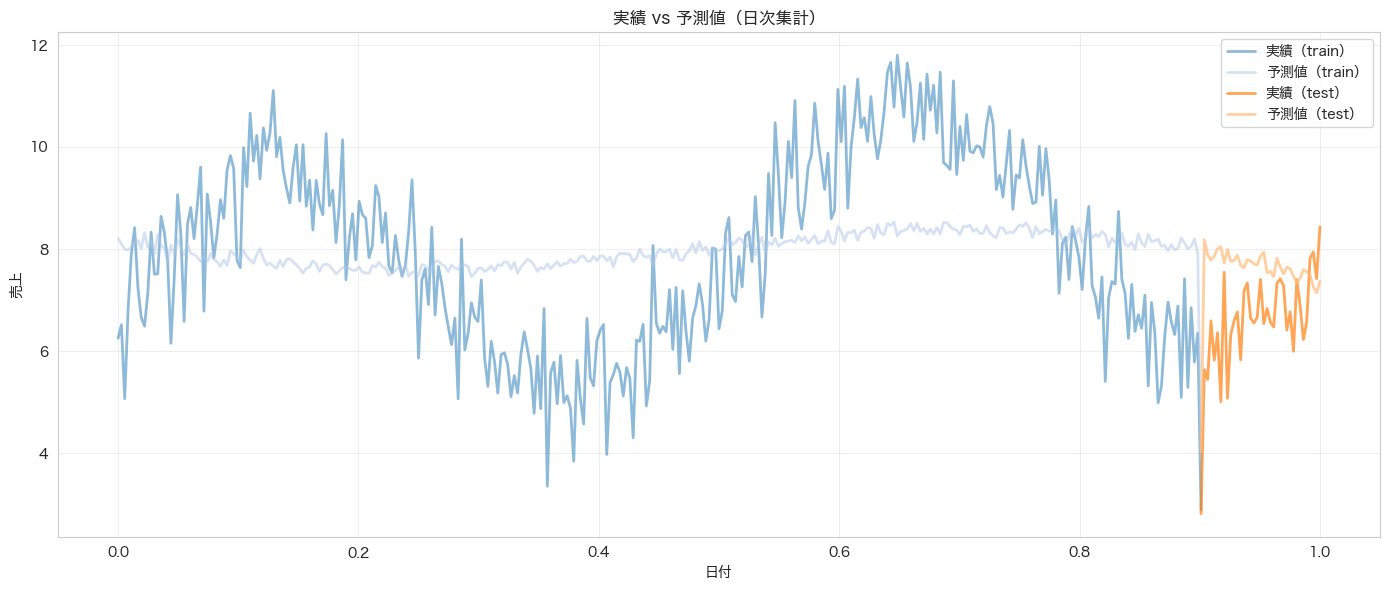

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


# データに分割
X_train_split, X_test_split, y_train_split, y_test_split = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()


# =====================================
# 1. 線形モデル: SVM (Support Vector Machine)
# =====================================

from sklearn.svm import SVR

# モデル作成と訓練
svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(X_train_split, y_train_split)

# 予測
y_pred_train_svm = svm_model.predict(X_train_split)
y_pred_svm = svm_model.predict(X_test_split)

# 評価
mse_svm = mean_squared_error(y_test_split, y_pred_svm)
r2_svm = r2_score(y_test_split, y_pred_svm)

print(f"MSE: {mse_svm:.2f}")
print(f"R²スコア: {r2_svm:.4f}")

plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_svm, y_pred_svm)

### 2. ツリーモデル Tree Models

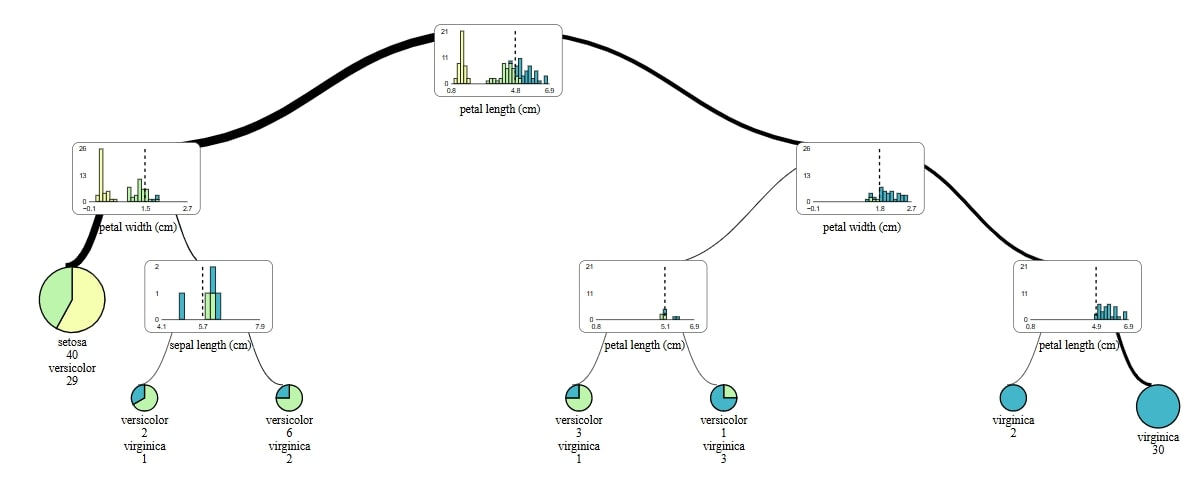

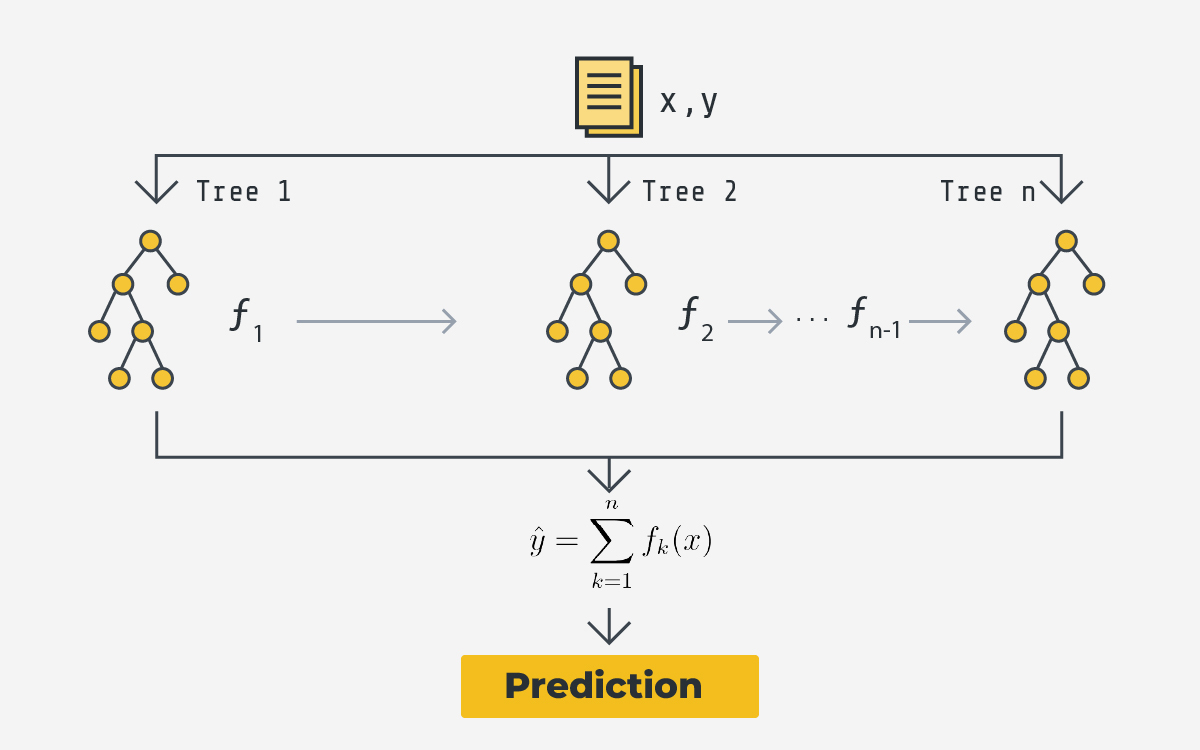

MSE: 0.04
R²スコア: -0.2066


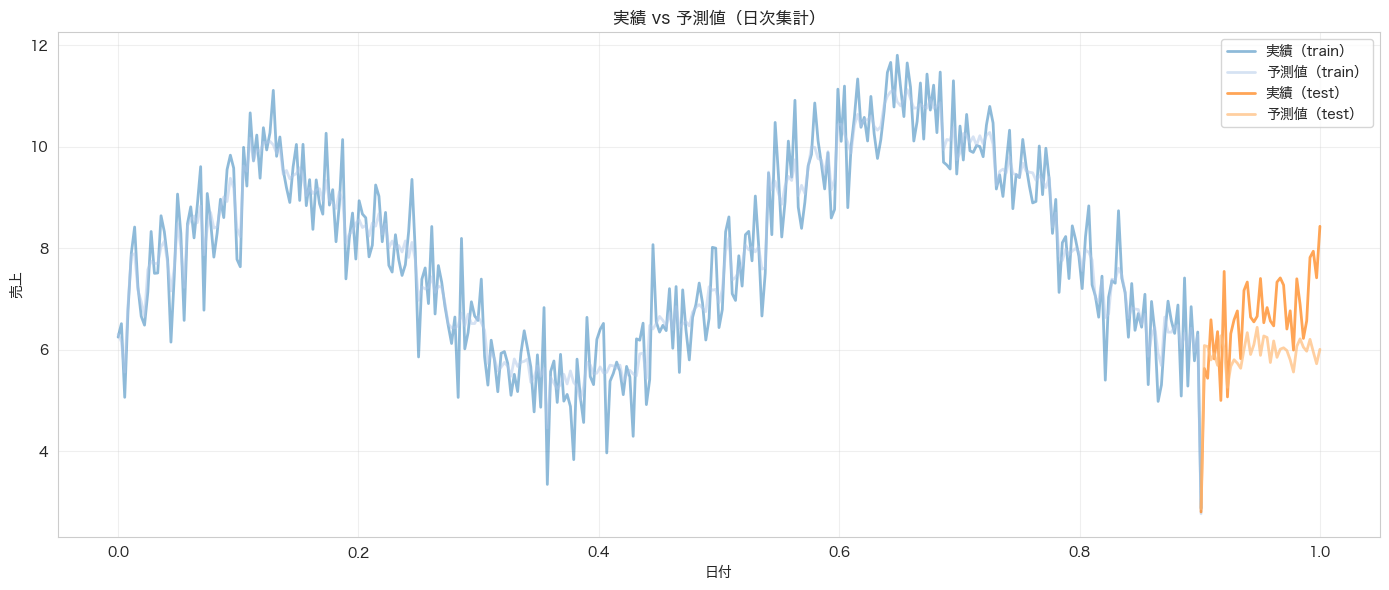

In [13]:

# =====================================
# 2. ツリーモデル: XGBoost
# =====================================

from xgboost import XGBRegressor

# データに分割
X_train_split, X_test_split, y_train_split, y_test_split = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# モデル作成と訓練
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_split, y_train_split)

# 予測
y_pred_train_xgb = xgb_model.predict(X_train_split)
y_pred_xgb = xgb_model.predict(X_test_split)

# 評価
mse_xgb = mean_squared_error(y_test_split, y_pred_xgb)
r2_xgb = r2_score(y_test_split, y_pred_xgb)

print(f"MSE: {mse_xgb:.2f}")
print(f"R²スコア: {r2_xgb:.4f}")

plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_xgb, y_pred_xgb)

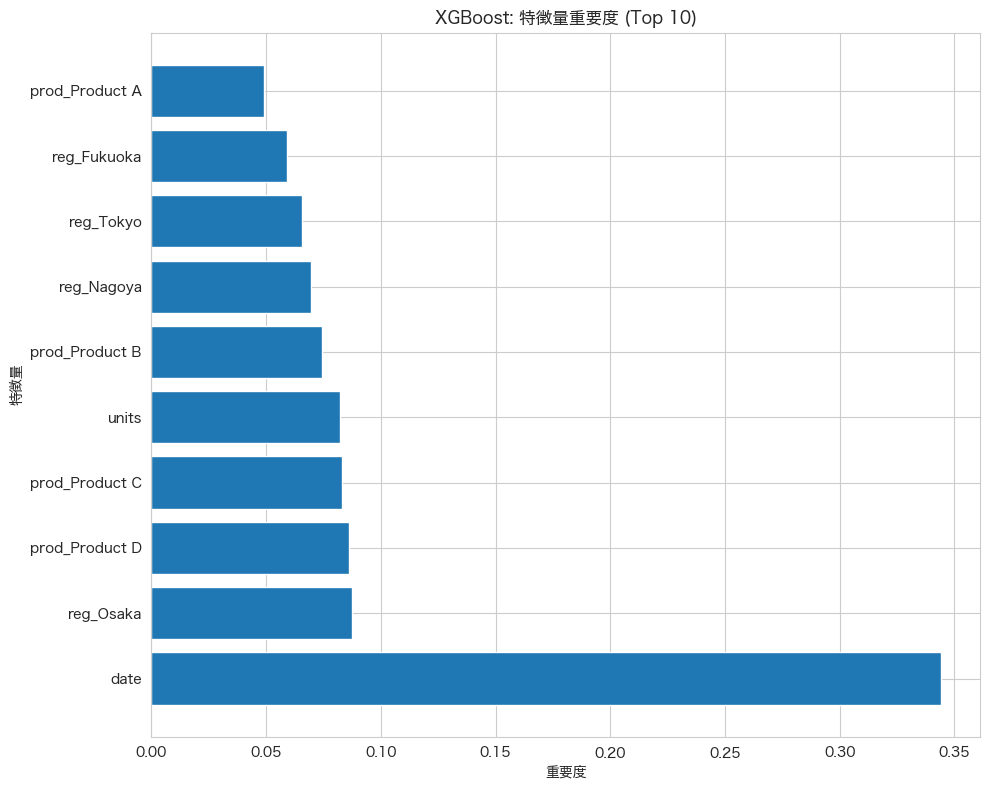

In [14]:
# 特徴量重要度のプロット
plt.figure(figsize=(10, 8))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('重要度')
plt.ylabel('特徴量')
plt.title('XGBoost: 特徴量重要度 (Top 10)')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()


### 3. Simple NN

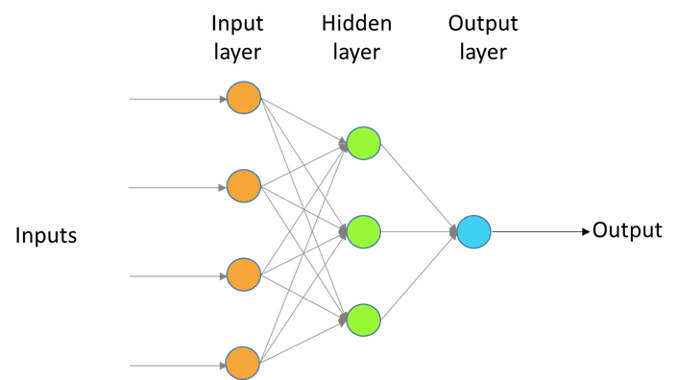

MSE: 0.07
R²スコア: -0.7705
反復回数: 126


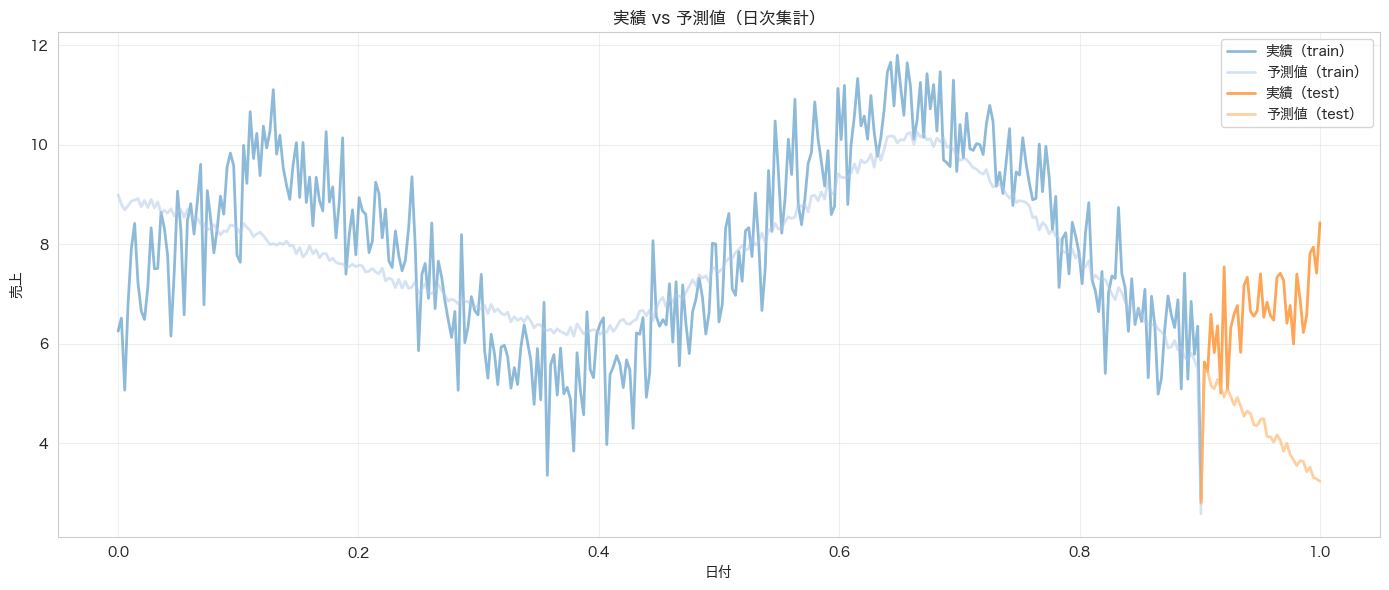

In [15]:

# =====================================
# 3. ニューラルネットワーク: Simple NN
# =====================================

from sklearn.neural_network import MLPRegressor

# モデル作成と訓練
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    early_stopping=True
)
nn_model.fit(X_train_split, y_train_split)

# 予測
y_pred_train_nn = nn_model.predict(X_train_split)
y_pred_nn = nn_model.predict(X_test_split)

# 評価
mse_nn = mean_squared_error(y_test_split, y_pred_nn)
r2_nn = r2_score(y_test_split, y_pred_nn)

print(f"MSE: {mse_nn:.2f}")
print(f"R²スコア: {r2_nn:.4f}")
print(f"反復回数: {nn_model.n_iter_}")

# プロット
plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_nn, y_pred_nn)

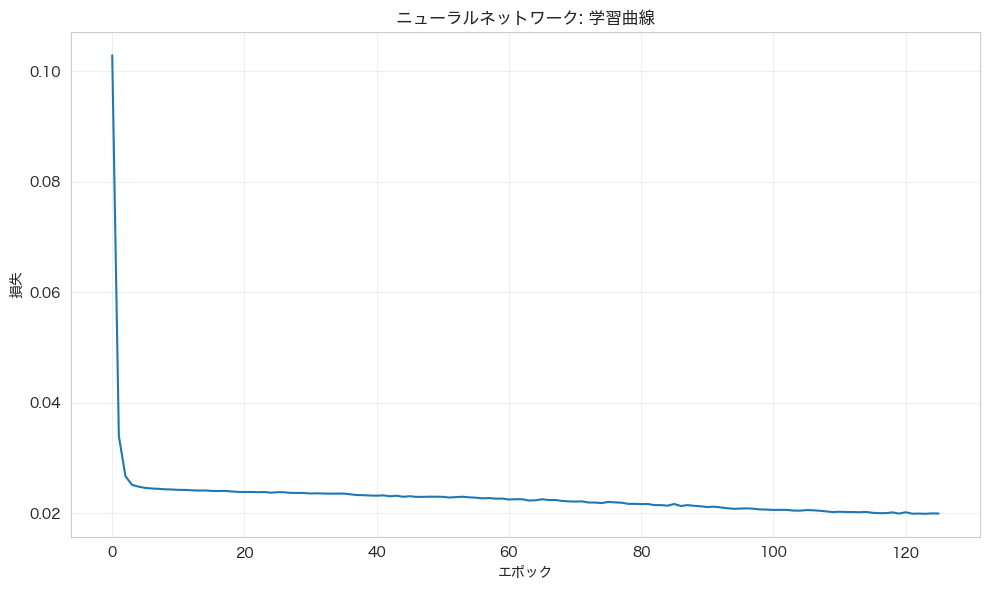

In [16]:

# 学習曲線のプロット
plt.figure(figsize=(10, 6))
plt.plot(nn_model.loss_curve_)
plt.xlabel('エポック')
plt.ylabel('損失')
plt.title('ニューラルネットワーク: 学習曲線')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('nn_learning_curve.png', dpi=150, bbox_inches='tight')
plt.show()


### 4. ディープラーニング

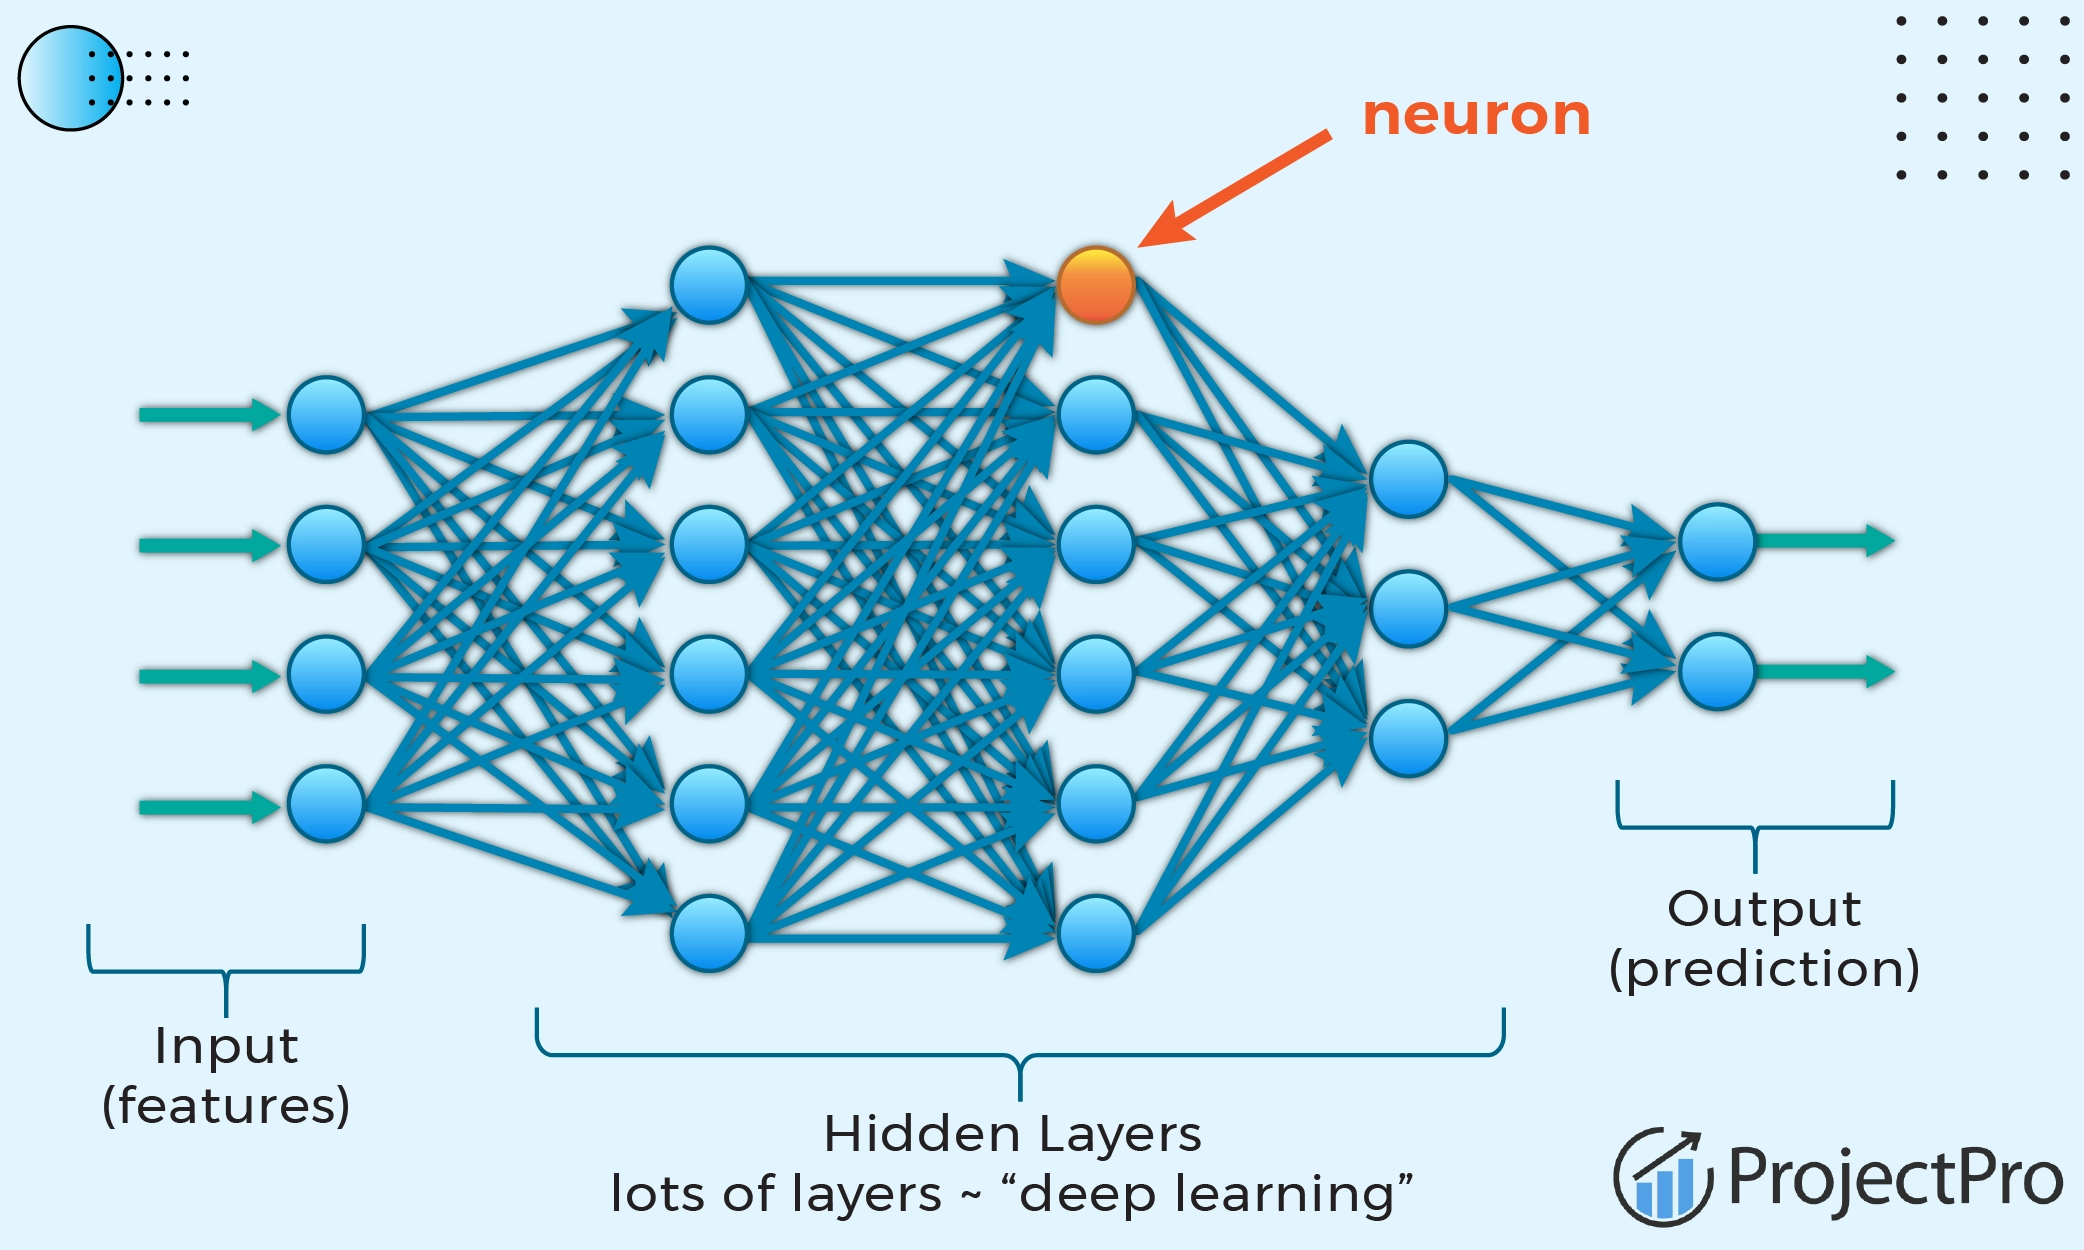

In [ ]:
# =====================================
# 4. ディープラーニング: 通常のニューラルネットワーク
# =====================================
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# データに分割
X_train_split, X_test_split, y_train_split, y_test_split = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# PyTorchテンソルに変換（時系列変換なし）
X_train_tensor = torch.FloatTensor(X_train_split.values)
y_train_tensor = torch.FloatTensor(y_train_split.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_split.values)
y_test_tensor = torch.FloatTensor(y_test_split.values).reshape(-1, 1)

print(f"トレーニングデータ: {X_train_tensor.shape}")
print(f"テストデータ: {X_test_tensor.shape}")

# データローダー作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 通常のニューラルネットワークモデル定義（3つの隠れ層）
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# モデル、損失関数、オプティマイザー
nn_model = FeedForwardNN(input_size=X_train_split.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

print("\nモデル構造:")
print(nn_model)

# 訓練
epochs = 200
train_losses = []
val_losses = []

print("\nトレーニング開始...")
for epoch in range(epochs):
    nn_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # 検証
    nn_model.eval()
    with torch.no_grad():
        val_pred = nn_model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
    
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}")

# 予測
nn_model.eval()
with torch.no_grad():
    y_pred_train_dl = nn_model(X_train_tensor).numpy().flatten()
    y_pred_dl = nn_model(X_test_tensor).numpy().flatten()

# 評価
mse_nn = mean_squared_error(y_test_split, y_pred_dl)
r2_nn = r2_score(y_test_split, y_pred_dl)

print(f"\nMSE: {mse_nn:.2f}")
print(f"R²スコア: {r2_nn:.4f}")


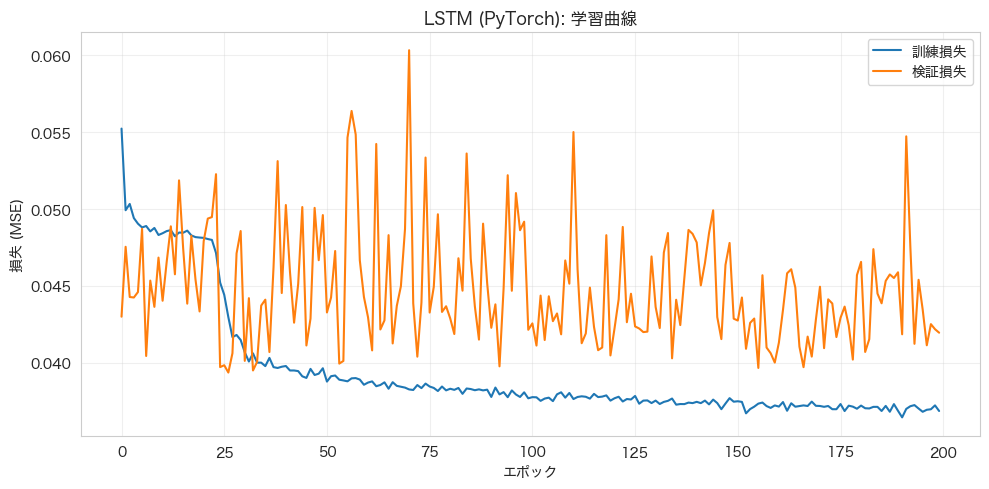

In [ ]:

# プロット: 学習履歴
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='訓練損失')
ax.plot(val_losses, label='検証損失')
ax.set_xlabel('エポック')
ax.set_ylabel('損失 (MSE)')
ax.set_title('LSTM (PyTorch): 学習曲線')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

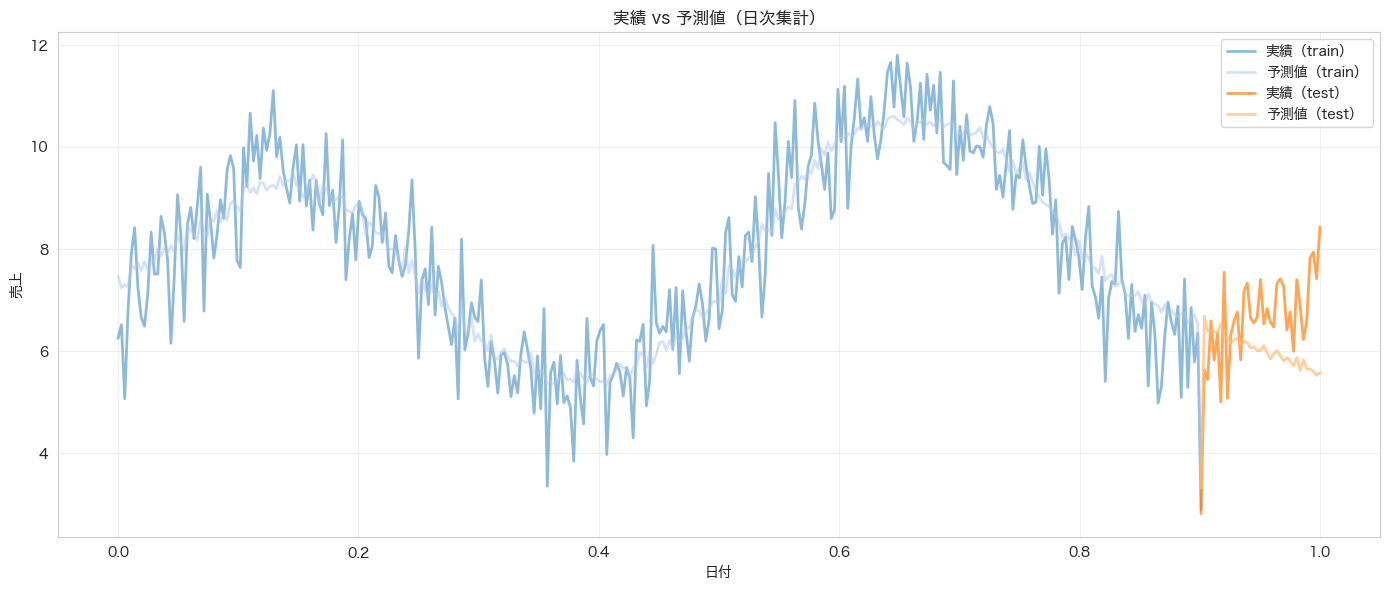

In [ ]:
plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_dl, y_pred_dl)

---
## 誤差メトリクス

### 誤差指標 (Error Metrics)

誤差指標は、モデルの予測精度を評価するための数値です。実際の値と予測値の差を様々な方法で測定し、モデルの性能を定量的に評価します。

#### 主要な誤差指標

**1. MAE (Mean Absolute Error) - 平均絶対誤差**

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

- 実際の値と予測値の絶対値の差の平均
- 単位: 元のデータと同じ単位
- 解釈: 平均的にどれくらい予測が外れているか
- 特徴: 外れ値の影響を受けにくい

**例:** MAE = 500円 → 平均して500円の誤差

**2. MSE (Mean Squared Error) - 平均二乗誤差**

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

- 誤差を二乗してから平均
- 単位: 元のデータの単位の二乗
- 特徴: 大きな誤差に重いペナルティ
- 用途: 訓練時の損失関数として使用

**例:** MSE = 250,000円² → 大きな誤差を強調

**3. RMSE (Root Mean Squared Error) - 平均二乗誤差平方根**

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

- MSEの平方根
- 単位: 元のデータと同じ単位
- 特徴: MSEと同じく大きな誤差を重視、MAEより解釈しやすい
- よく使われる: 標準的な誤差指標

**例:** RMSE = 500円 → MAEと同じ単位で比較可能

**4. MAPE (Mean Absolute Percentage Error) - 平均絶対パーセント誤差**

$$\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left|\frac{y_i - \hat{y}_i}{y_i}\right|$$

- パーセンテージで表現した誤差
- 単位: パーセント (%)
- 特徴: スケールに依存しない
- 注意: 実際の値が0に近いと不安定

**例:** MAPE = 5% → 平均して5%の誤差

**5. R² (決定係数) - R-squared**

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

- モデルがデータの分散をどれだけ説明できるか
- 範囲: -∞ から 1（通常は0から1）
- 解釈: 1に近いほど良い予測
- 特徴: スケールに依存しない

**例:** R² = 0.85 → モデルが分散の85%を説明

#### 指標の比較

| 指標 | 単位 | 範囲 | 外れ値の影響 | 解釈のしやすさ |
|------|------|------|--------------|----------------|
| MAE | 元の単位 | [0, ∞) | 小 | ★★★ 高い |
| MSE | 単位² | [0, ∞) | 大 | ★ 低い |
| RMSE | 元の単位 | [0, ∞) | 大 | ★★★ 高い |
| MAPE | % | [0, ∞) | 中 | ★★★ 高い |
| R² | なし | (-∞, 1] | 中 | ★★ 中程度 |



In [ ]:
# utils: 誤差関数

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    各種誤差指標を計算して返す
    
    Parameters:
    -----------
    y_true : array-like
        実際の値
    y_pred : array-like
        予測値
    model_name : str
        モデル名（表示用）
    
    Returns:
    --------
    dict : 各指標の値
    """
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    
    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    
    # MAPE (Mean Absolute Percentage Error)
    # ゼロ除算を避けるため、y_trueが0でない要素のみで計算
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # R² (R-squared)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }


def print_metrics(y_true, y_pred, model_name="Model"):
    """
    誤差指標を計算して綺麗に表示
    """
    metrics = calculate_metrics(y_true, y_pred, model_name)
    
    print(f"\n{'='*60}")
    print(f"{metrics['Model']} の誤差指標")
    print(f"{'='*60}")
    print(f"MAE  (平均絶対誤差):           {metrics['MAE']:>12,.2f}")
    print(f"MSE  (平均二乗誤差):           {metrics['MSE']:>12,.2f}")
    print(f"RMSE (平均二乗誤差平方根):     {metrics['RMSE']:>12,.2f}")
    print(f"MAPE (平均絶対パーセント誤差): {metrics['MAPE']:>12,.2f}%")
    print(f"R²   (決定係数):               {metrics['R²']:>12,.4f}")
    print(f"{'='*60}\n")
    
    return metrics


def compare_models(y_true, predictions_dict):
    """
    複数のモデルの誤差指標を比較
    
    Parameters:
    -----------
    y_true : array-like
        実際の値
    predictions_dict : dict
        {モデル名: 予測値} の辞書
    """
    results = []
    
    for model_name, y_pred in predictions_dict.items():
        metrics = calculate_metrics(y_true, y_pred, model_name)
        results.append(metrics)
    
    # DataFrameに変換
    df_results = pd.DataFrame(results)
    
    # 表示用にフォーマット
    print("\n" + "="*80)
    print("モデル比較: 誤差指標一覧")
    print("="*80)
    print(df_results.to_string(index=False))
    print("="*80)
    
    # 最良のモデルを特定
    print("\n【最良モデル】")
    print(f"最小MAE:  {df_results.loc[df_results['MAE'].idxmin(), 'Model']}")
    print(f"最小RMSE: {df_results.loc[df_results['RMSE'].idxmin(), 'Model']}")
    print(f"最大R²:   {df_results.loc[df_results['R²'].idxmax(), 'Model']}")
    
    return df_results


def plot_metrics_comparison(df_results):
    """
    誤差指標の比較グラフを作成
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    models = df_results['Model']
    
    # MAE
    axes[0, 0].bar(models, df_results['MAE'], color='skyblue')
    axes[0, 0].set_title('MAE (平均絶対誤差)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # RMSE
    axes[0, 1].bar(models, df_results['RMSE'], color='lightcoral')
    axes[0, 1].set_title('RMSE (平均二乗誤差平方根)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # MAPE
    axes[1, 0].bar(models, df_results['MAPE'], color='lightgreen')
    axes[1, 0].set_title('MAPE (平均絶対パーセント誤差)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('MAPE (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # R²
    axes[1, 1].bar(models, df_results['R²'], color='plum')
    axes[1, 1].set_title('R² (決定係数)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('R²')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()



モデル比較: 誤差指標一覧
  Model      MAE      MSE     RMSE      MAPE        R²
    SVM 0.179306 0.044848 0.211773 74.168753 -0.203489
XGBoost 0.174006 0.044963 0.212045 56.368357 -0.206584
     NN 0.177691 0.043446 0.208438 75.647235 -0.165879
     DL 0.165619 0.037856 0.194565 61.999156 -0.015854

【最良モデル】
最小MAE:  DL
最小RMSE: DL
最大R²:   DL


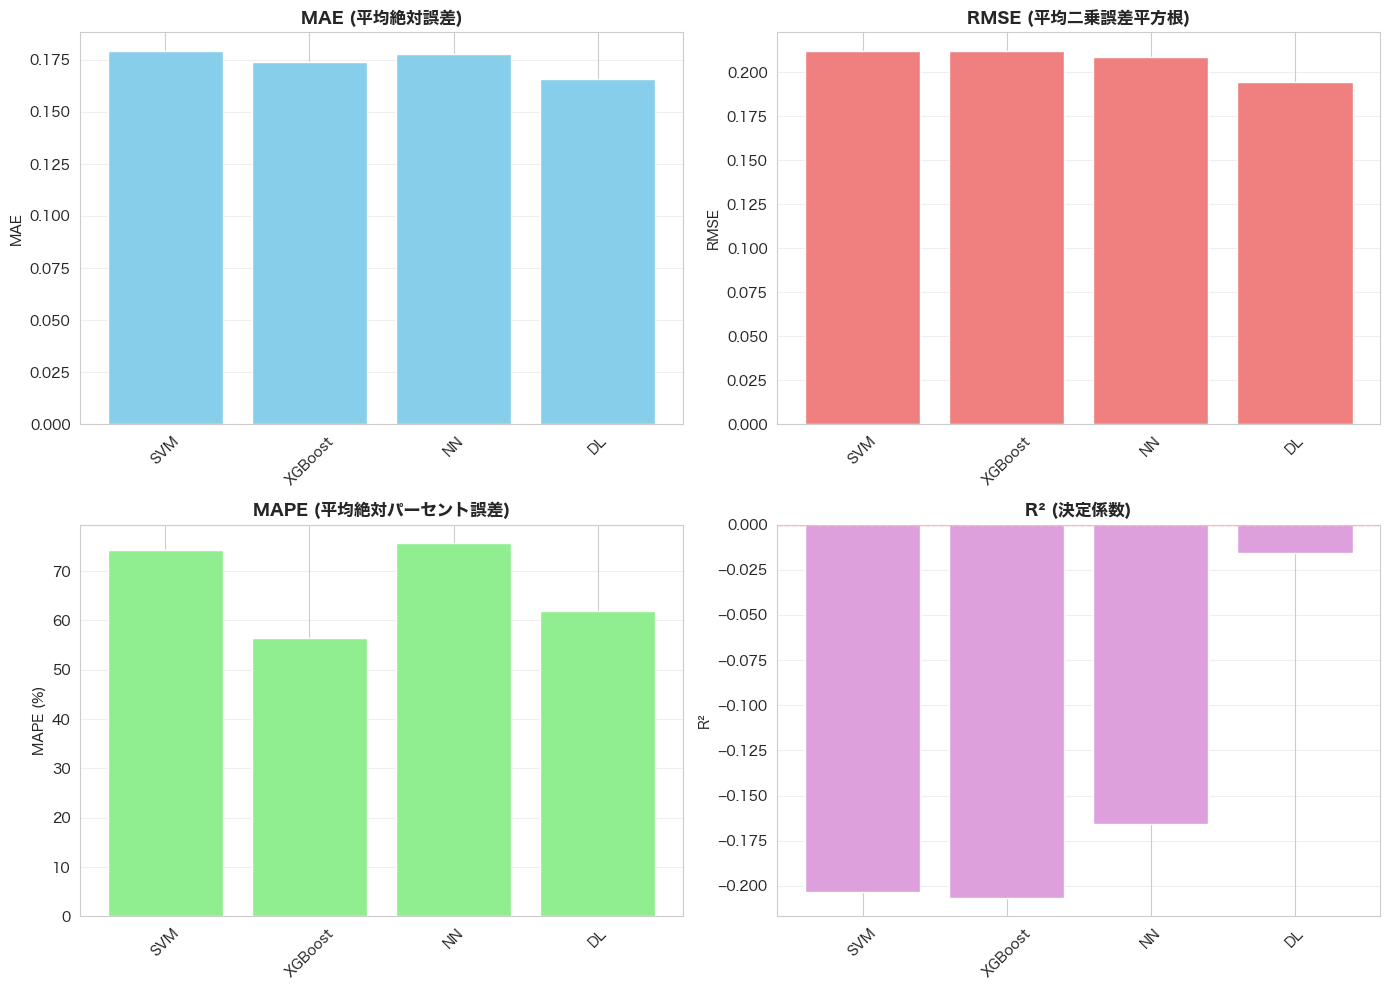

In [ ]:
predictions = {
    'SVM': y_pred_svm,
    'XGBoost': y_pred_xgb,
    'NN': y_pred_nn,
    'DL': y_pred_dl
}

# Compare all models and display table
df_results = compare_models(y_test, predictions)

# Plot the comparison
plot_metrics_comparison(df_results)


---
## 特徴量
特徴量とは、機械学習モデルへの入力となるデータの各列（変数）のことです。モデルは特徴量からパターンを学習し、予測を行います。特徴量の質と選択が、モデルの性能を大きく左右します。

#### 1. 特徴量エンジニアリング (Feature Engineering)

特徴量エンジニアリングは、既存のデータから新しい特徴量を作成したり、既存の特徴量を変換してモデルの性能を向上させる技術です。

#### 2. 特徴量選択 (Feature Selection)

すべての特徴量が有用とは限りません。不要な特徴量はモデルの性能を低下させる可能性があります。


In [ ]:
X.columns

Index(['prod_Product A', 'prod_Product B', 'prod_Product C', 'prod_Product D',
       'cat_Books', 'cat_Clothing', 'cat_Electronics', 'cat_Food',
       'reg_Fukuoka', 'reg_Nagoya', 'reg_Osaka', 'reg_Tokyo', 'date', 'sales',
       'units'],
      dtype='object')

In [ ]:
# =====================================
# 特徴量エンジニアリング: 過去7日間の平均売上
# =====================================

# 製品×地域ごとにグループ化して、過去7日間の平均を計算
sales_data = sales_data.sort_values(['product', 'region', 'date']).reset_index(drop=True)

sales_data['sales_last_7days_avg'] = sales_data.groupby(['product', 'region'])['sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean().shift(1)
)
sales_data['sales_last_7days_avg'] = sales_data['sales_last_7days_avg'].fillna(0)



In [ ]:
sales_data

date    product     category   region        sales  units    month  \
0    2024-01-01  Product A  Electronics  Fukuoka  4725.000000     99  2024-01   
1    2024-01-02  Product A  Electronics  Fukuoka  2672.654322     54  2024-01   
2    2024-01-03  Product A  Electronics  Fukuoka  7857.234590     10  2024-01   
3    2024-01-04  Product A  Electronics  Fukuoka  3985.666833     82  2024-01   
4    2024-01-05  Product A  Electronics  Fukuoka  9836.877245     49  2024-01   
...         ...        ...          ...      ...          ...    ...      ...   
5835 2024-12-26  Product D        Books    Tokyo  3793.854164     93  2024-12   
5836 2024-12-27  Product D        Books    Tokyo  2016.696814     50  2024-12   
5837 2024-12-28  Product D        Books    Tokyo  7461.668585     30  2024-12   
5838 2024-12-29  Product D        Books    Tokyo  6116.705071     12  2024-12   
5839 2024-12-30  Product D        Books    Tokyo  3227.740680     78  2024-12   

      sales_last_7days_avg  
0                 0.000000  
1              4725.000000  
2              3698.827161  
3              5084.962971  
4              4810.138936  
...                    ...  
5835           5625.592163  
5836           5351.185557  
5837           4471.292269  
5838           4107.282027  
5839           4091.808816  

[5840 rows x 8 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

X = sales_data.copy()

# ワンホットエンコーディング実行
X_encoded = pd.get_dummies(X, columns=['product', 'category', 'region'], prefix=['prod', 'cat', 'reg']).astype(int)

# 日付列を数値に変換
if 'date' in X.columns:
    X['date'] = X['date'].astype('int64') / 10**9  # Unixタイムスタンプ（秒）

# 数値列のみを選択
numeric_columns = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
X_numeric = X[numeric_columns].copy()

# =====================================
# 正規化例（Min-Max Normalization）
# =====================================

# salesとunitsを正規化
scaler_minmax = MinMaxScaler()
columns_to_normalize = ['date', 'sales', 'units', 'sales_last_7days_avg']

X_normalized = X_numeric.copy()
X_normalized[columns_to_normalize] = scaler_minmax.fit_transform(X_numeric[columns_to_normalize])
y = X_normalized['sales']

X = pd.concat([X_encoded.drop(columns=['date', 'month', 'sales', 'units', 'sales_last_7days_avg']), X_normalized[['date', 'sales', 'sales_last_7days_avg', 'units']]], axis=1)

X.head(5)

prod_Product A  prod_Product B  prod_Product C  prod_Product D  cat_Books  \
0               1               0               0               0          0   
1               1               0               0               0          0   
2               1               0               0               0          0   
3               1               0               0               0          0   
4               1               0               0               0          0   

   cat_Clothing  cat_Electronics  cat_Food  reg_Fukuoka  reg_Nagoya  \
0             0                1         0            1           0   
1             0                1         0            1           0   
2             0                1         0            1           0   
3             0                1         0            1           0   
4             0                1         0            1           0   

   reg_Osaka  reg_Tokyo      date     sales  sales_last_7days_avg     units  
0          0          0  0.000000  0.369512              0.000000  1.000000  
1          0          0  0.002747  0.215566              0.411379  0.494382  
2          0          0  0.005495  0.604459              0.322036  0.000000  
3          0          0  0.008242  0.314055              0.442719  0.808989  
4          0          0  0.010989  0.752950              0.418792  0.438202

In [ ]:
split_idx = int(len(X) * 0.9)

X_train = X[:split_idx].drop(columns=['sales'])
X_test = X[split_idx:].drop(columns=['sales'])
y_train = y[:split_idx]
y_test = y[split_idx:]


MSE: 0.04
R²スコア: 0.1926


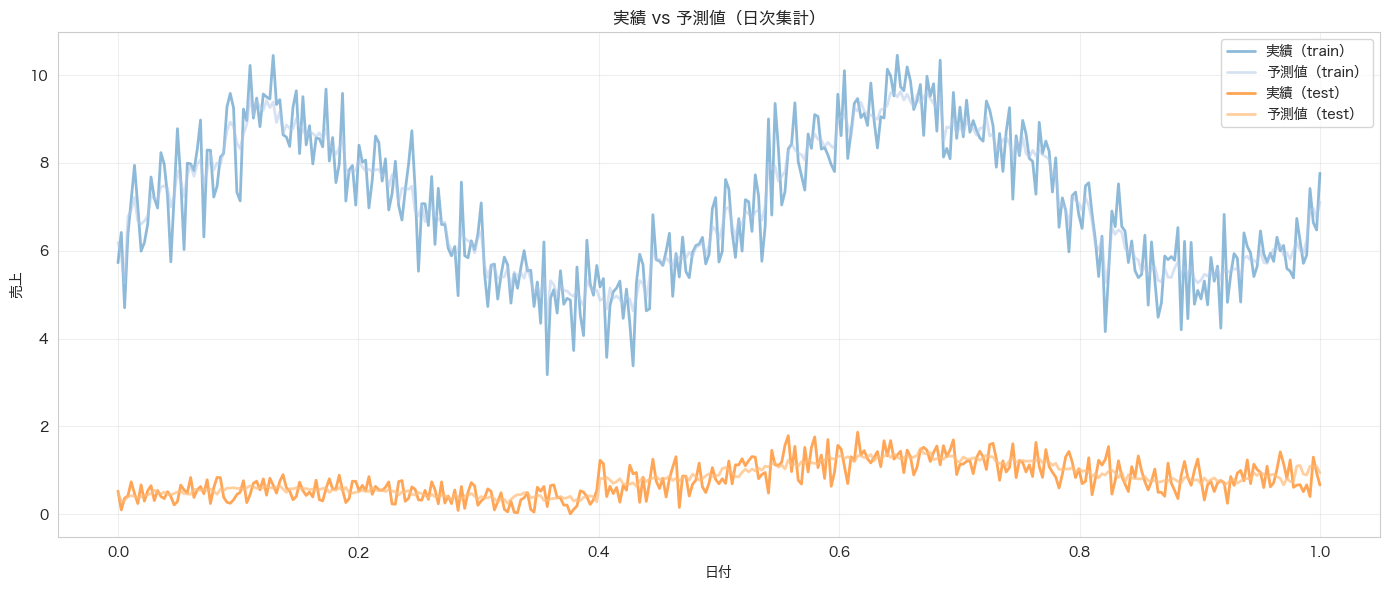

In [ ]:

# =====================================
# 2. ツリーモデル: XGBoost
# =====================================

from xgboost import XGBRegressor

# データに分割
X_train_split, X_test_split, y_train_split, y_test_split = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# モデル作成と訓練
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_split, y_train_split)

# 予測
y_pred_train_xgb = xgb_model.predict(X_train_split)
y_pred_xgb = xgb_model.predict(X_test_split)

# 評価
mse_xgb = mean_squared_error(y_test_split, y_pred_xgb)
r2_xgb = r2_score(y_test_split, y_pred_xgb)

print(f"MSE: {mse_xgb:.2f}")
print(f"R²スコア: {r2_xgb:.4f}")

plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_xgb, y_pred_xgb)

---
## Appendix 

### 5. ディープラーニング: 通常のニューラルネットワーク（正則化付き）

In [ ]:
# =====================================
# 5. ディープラーニング: 通常のニューラルネットワーク（正則化付き）
# =====================================
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# データに分割
X_train_split, X_test_split, y_train_split, y_test_split = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# PyTorchテンソルに変換（時系列変換なし）
X_train_tensor = torch.FloatTensor(X_train_split.values)
y_train_tensor = torch.FloatTensor(y_train_split.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_split.values)
y_test_tensor = torch.FloatTensor(y_test_split.values).reshape(-1, 1)

print(f"トレーニングデータ: {X_train_tensor.shape}")
print(f"テストデータ: {X_test_tensor.shape}")

# データローダー作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # バッチサイズを増やす

# 通常のニューラルネットワークモデル定義（3つの隠れ層 + 正則化）
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # バッチ正規化
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   # バッチ正規化
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)   # バッチ正規化
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3) 
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# モデル、損失関数、オプティマイザー（L2正則化付き）
nn_model = FeedForwardNN(input_size=X_train_split.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-4)  # L2正則化 (weight_decay)

print("\nモデル構造:")
print(nn_model)

# 早期停止の設定
patience = 20
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# 訓練
epochs = 100
train_losses = []
val_losses = []

# モデル、損失関数、オプティマイザー（L2正則化付き）
nn_model = FeedForwardNN(input_size=X_train_split.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-4)  # L2正則化 (weight_decay)

# L1正則化の係数
l1_lambda = 1e-5

for epoch in range(epochs):
    nn_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        l1_norm = sum(p.abs().sum() for p in nn_model.parameters())
        loss = criterion(outputs, y_batch) + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # 検証
    nn_model.eval()
    with torch.no_grad():
        val_pred = nn_model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
    
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss.item())
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}")
 

# ベストモデルをロード
if best_model_state is not None:
    nn_model.load_state_dict(best_model_state)
    print(f"ベストモデル (Val Loss: {best_val_loss:.2f}) をロードしました")

# 予測
nn_model.eval()
with torch.no_grad():
    y_pred_train_dl_2 = nn_model(X_train_tensor).numpy().flatten()
    y_pred_dl_2 = nn_model(X_test_tensor).numpy().flatten()

# 評価
mse_nn = mean_squared_error(y_test_split, y_pred_dl_2)
r2_nn = r2_score(y_test_split, y_pred_dl_2)

print(f"\nMSE: {mse_nn:.2f}")
print(f"R²スコア: {r2_nn:.4f}")

トレーニングデータ: torch.Size([5256, 14])
テストデータ: torch.Size([584, 14])

モデル構造:
FeedForwardNN(
  (fc1): Linear(in_features=14, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch [10/200], Train Loss: 0.06, Val Loss: 0.04
Epoch [20/200], Train Loss: 0.06, Val Loss: 0.04
Epoch [30/200], Train Loss: 0.06, Val Loss: 0.05
Epoch [40/200], Train Loss: 0.05, Val Loss: 0.05
Epoch [50/200], Train Loss: 0.05, Val Loss: 0.04
Epoch [60/200], Train Loss: 0.04, Val Loss: 0.04
Epoch [70/200], Train Loss: 0.04, Val Loss: 0.04

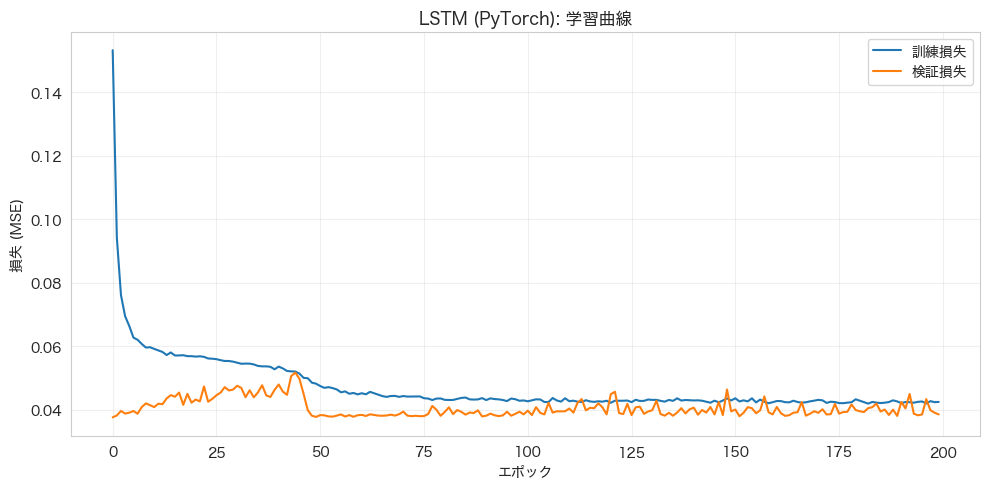

In [ ]:
# プロット: 学習履歴
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='訓練損失')
ax.plot(val_losses, label='検証損失')
ax.set_xlabel('エポック')
ax.set_ylabel('損失 (MSE)')
ax.set_title('LSTM (PyTorch): 学習曲線')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

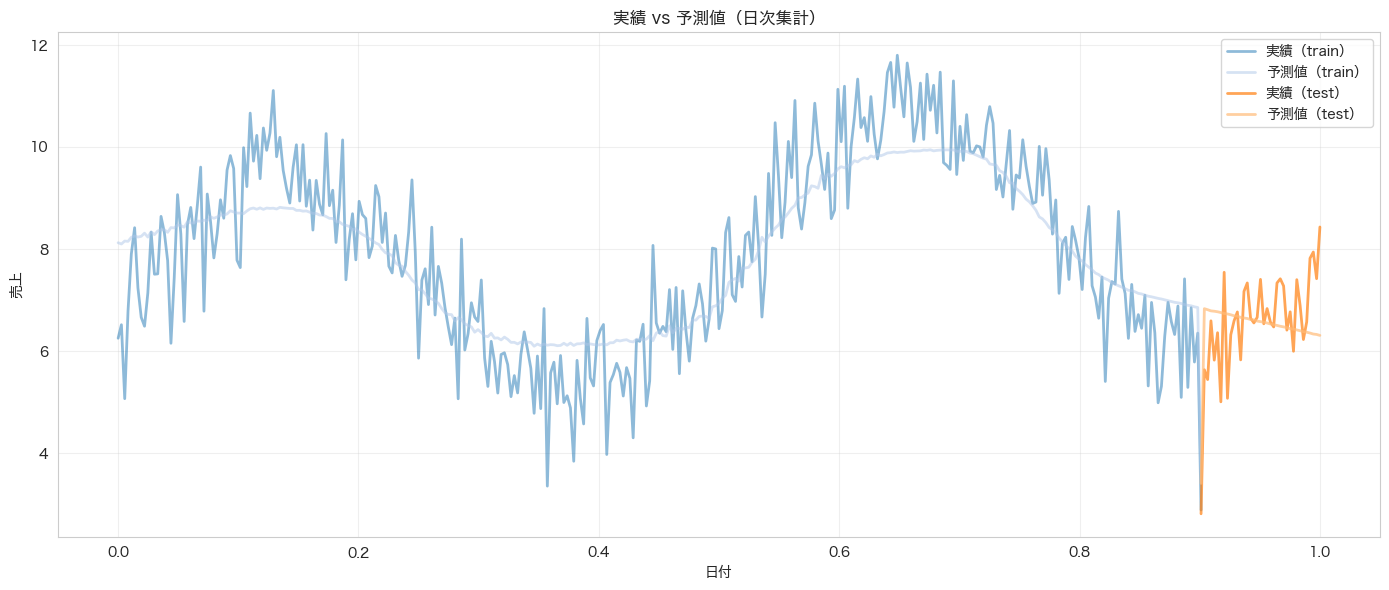

In [ ]:
plot(X_train_split, X_test_split, y_train_split, y_test_split, y_pred_train_dl_2, y_pred_dl_2)


モデル比較: 誤差指標一覧
  Model      MAE      MSE     RMSE      MAPE        R²
    SVM 0.179306 0.044848 0.211773 74.168753 -0.203489
XGBoost 0.174006 0.044963 0.212045 56.368357 -0.206584
     NN 0.177691 0.043446 0.208438 75.647235 -0.165879
     DL 0.165619 0.037856 0.194565 61.999156 -0.015854
   DL_2 0.165541 0.037976 0.194875 60.652085 -0.019091

【最良モデル】
最小MAE:  DL_2
最小RMSE: DL
最大R²:   DL


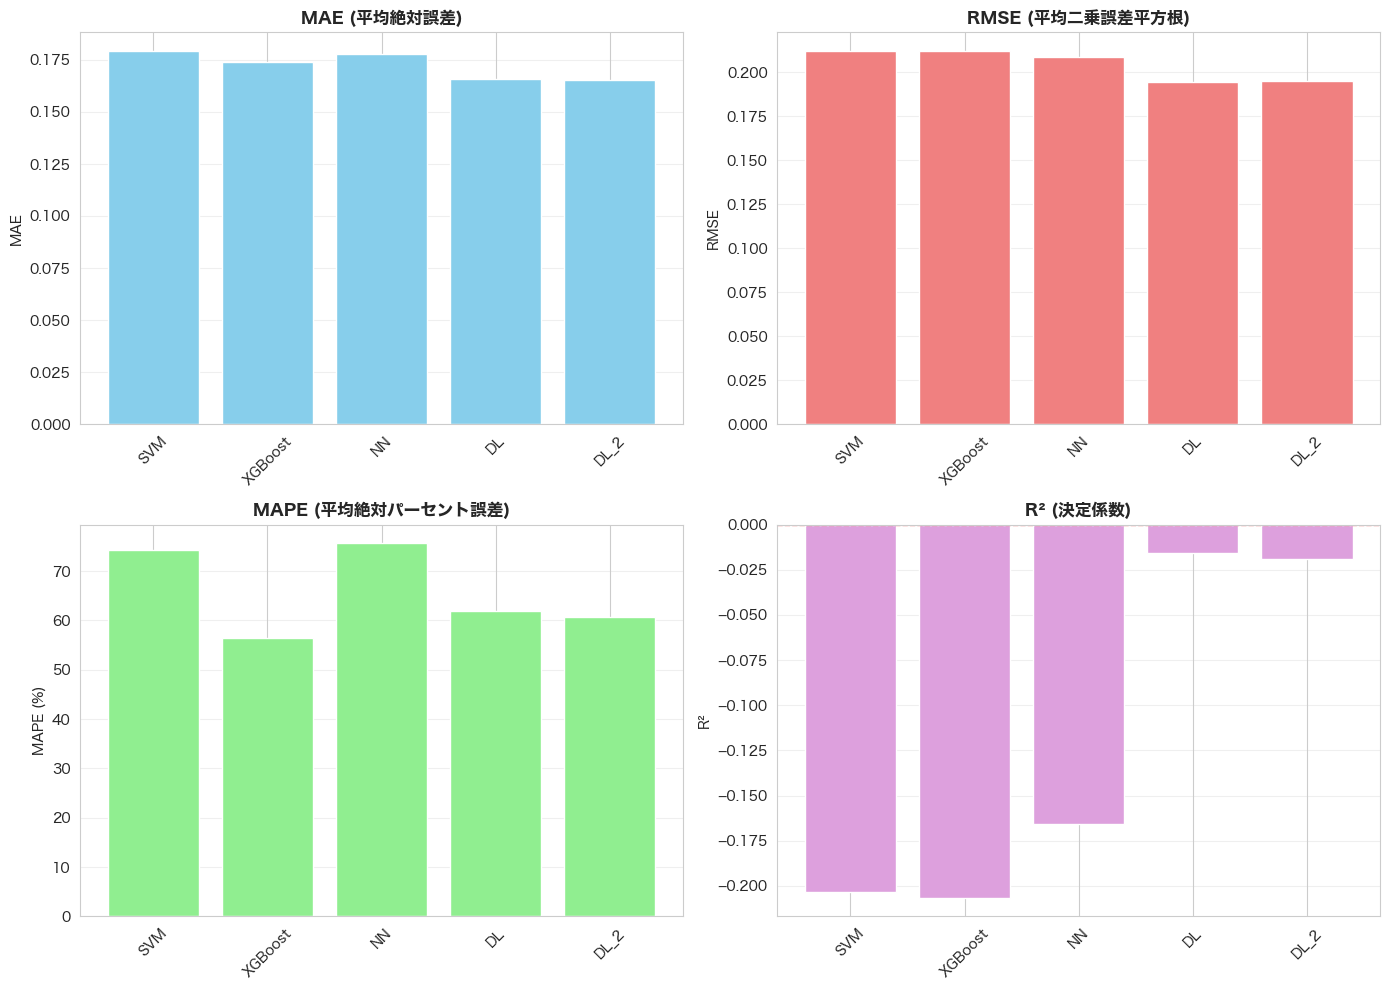

In [ ]:
predictions = {
    'SVM': y_pred_svm,
    'XGBoost': y_pred_xgb,
    'NN': y_pred_nn,
    'DL': y_pred_dl,
    'DL_2': y_pred_dl_2

}

# Compare all models and display table
df_results = compare_models(y_test, predictions)

# Plot the comparison
plot_metrics_comparison(df_results)
